## Attachment 3: MAVE-NN

The reviewers requested that we use the MAVE-NN package to interpret out FACS-NGS scores, instead of presenting a statistical analysis of the active kinase variants as a group. Any analysis is based on the following evidence derived from the FACS-NGS process: each variant has a genotype, phenotype, the distribution across FACS bins and the associated NGS read distribution, such that each step in the process is both a direct reflection of the previous steps and influenced by the noise in the process.

The ambition of MAVE-NN is to work backwards: 1) inferring phenotypes from the NGS distribution, then 2) interpreting the genotype-phenotype map to distinguish between global and local effects.

In order to take advantage of this process, the training set for MAVE-NN has to include active variants, inactive variants and everything in-between. Here, the trial MAVE-NN dataset is constructed with 386K variants that have at least 10 reads across the three gates. The emphasis is not on the exact set of variants to include (the borderlines are from the low set anyway), but on obtaining a valid estimation of variant phenotypes from the NGS data.

In [1]:
import sys
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logomaker

import mavenn

os.chdir("/mnt/c/Users/Maya/Documents/03_Kinases/")

Matplotlib is building the font cache; this may take a moment.


First, the SpliMLiB dataset is imported and the header displayed to check formatting and columns names.

In [2]:
with open('splimlib_mave.pickle', 'rb') as f:
    df_sml = pickle.load(f)

In [3]:
df_sml.head()

,mutations,ct_2,ct_1,ct_0,sequences
0,6L/7aI/8aA/9L/11F/13M,1185.0,33.0,6.0,LIALFM
1,6F/7aP/9W/11L/13M,903.0,81.0,15.0,FPΔWLM
2,6L/7aF/9L/11I/13I,899.0,2.0,8.0,LFΔLII
3,6A/7aI/8aA/9L/11L/13I,893.0,3.0,19.0,AIALLI
4,6W/7aI/9F/11L/13V,880.0,34.0,20.0,WIΔFLV


The column headers are as follows:
- mutation: each variant listing the mutation from WT caMKK1. Note that changes at positions 7a and 8a are listed only if there is an insertion present.
- ct_2: count of sequencing reads in the high gate
- ct_1: sequencing reads in medium gate
- ct_0: sequencing reads in low gate
- sequences: the amino acid resides in the six randomised positions, without intervening constant residues.

This format is compatible with MAVE-NN.

Next, generate some descriptive statistics of this dataset.

In [4]:
df_sml.describe()

,ct_2,ct_1,ct_0
count,386031.000000,386031.000000,386031.000000
mean,12.008556,7.701433,15.616425
std,45.869569,12.625967,8.688312
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,10.000000
50%,0.000000,1.000000,14.000000
75%,0.000000,12.000000,20.000000
max,1185.000000,165.000000,95.000000


The signal from the NGS is normalised to convert into percentage of reads in each of the three NGS gates: these are now listed in columns 'high', 'med' and 'low'.

In [5]:
df_per = df_sml
df_per[['high', 'med', 'low']] = df_sml[['ct_2', 'ct_1', 'ct_0']].div(df_sml[['ct_2', 'ct_1', 'ct_0']].sum(axis=1), axis=0).mul(100).round(3)
df_per.head()

,mutations,ct_2,ct_1,ct_0,sequences,high,med,low
0,6L/7aI/8aA/9L/11F/13M,1185.0,33.0,6.0,LIALFM,96.814,2.696,0.490
1,6F/7aP/9W/11L/13M,903.0,81.0,15.0,FPΔWLM,90.390,8.108,1.502
2,6L/7aF/9L/11I/13I,899.0,2.0,8.0,LFΔLII,98.900,0.220,0.880
3,6A/7aI/8aA/9L/11L/13I,893.0,3.0,19.0,AIALLI,97.596,0.328,2.077
4,6W/7aI/9F/11L/13V,880.0,34.0,20.0,WIΔFLV,94.218,3.640,2.141


In our hands attempts at getting a sensible result from the MAVE-NN were unsuccessful with random sampling of this large set of variants, whether using NGS counts or the percentage distribution between bins. We suspect the likely reason for this failure is that the full dataset is strongly biased towards low-activity variants (as most mutants are compromised in their function and were sorted in the low gate) - consequently all models just allocate all variants to a low-activity phenotype. A realistic model should instead predict that the numerically estimated latent phenotype is very negative for low gate sequences, rising for variants abundant in the high gate.

To remedy this situation, we constructed a stratified training set, which creates unequal test-train splits in three different sections. Here, it is not truly important where the boundaries between the groups are (certainly the "high" group is fairly permissive), but that the relative group sizes are approximately balanced. Specifically:

- high (high > 25): place 80% in training set 
- mostly medium (high < 25, med: place 10% in training set 
- very low (high < 1, med < 10): place 5% in training set
- everything else: place 10% in training set

In [6]:
print('High: ', df_sml.loc[df_sml['high'] > 25].count().sequences) # highest

High:  38820


In [7]:
print('Low to medium: ', df_sml.loc[(df_sml['high'] <= 25) & (df_sml['med'] >=10)].count().sequences) # low to medium

Low to medium:  143504


In [8]:
print('Very low: ', df_sml.loc[(df_sml['high'] < 1) & (df_sml['med'] < 10)].count().sequences ) # very low

Very low:  182457


In [9]:
df_sml['stratify'] = 0 # assign everything to group 0 first, just to make sure nothing is without an assignemnt
df_sml.loc[df_sml['high'] > 25, 'stratify'] = 1 # high
df_sml.loc[(df_sml['high'] <= 25) & (df_sml['med'] >=10), 'stratify'] = 2
df_sml.loc[(df_sml['high'] < 1) & (df_sml['med'] < 10), 'stratify'] = 3
df_sml.loc[(df_sml['high'] >=1) & (df_sml['high'] <= 25) & (df_sml['med'] < 10), 'stratify'] = 4

In [10]:
data_df = df_sml
# Assign to training and test sets
N = len(data_df)
np.random.seed(2000)
r = np.random.rand(N) # get an array of N random numbers between 0 and 1, uniform distribution
data_df['set'] = 'test'

Checking that the final constructed dataset makes sense:

In [11]:
data_df

,mutations,ct_2,ct_1,ct_0,sequences,high,med,low,stratify,set
0,6L/7aI/8aA/9L/11F/13M,1185.0,33.0,6.0,LIALFM,96.814,2.696,0.490,1,test
1,6F/7aP/9W/11L/13M,903.0,81.0,15.0,FPΔWLM,90.390,8.108,1.502,1,test
2,6L/7aF/9L/11I/13I,899.0,2.0,8.0,LFΔLII,98.900,0.220,0.880,1,test
3,6A/7aI/8aA/9L/11L/13I,893.0,3.0,19.0,AIALLI,97.596,0.328,2.077,1,test
4,6W/7aI/9F/11L/13V,880.0,34.0,20.0,WIΔFLV,94.218,3.640,2.141,1,test
...,...,...,...,...,...,...,...,...,...,...
386026,6P/7aL/9P/11G/13K,0.0,0.0,10.0,PLΔPGK,0.000,0.000,100.000,3,test
386027,6M/7aV/8aA/9Y/11P/13W,0.0,0.0,10.0,MVAYPW,0.000,0.000,100.000,3,test
386028,6L/7aW/9Y/11I/13G,0.0,0.0,10.0,LWΔYIG,0.000,0.000,100.000,3,test
386029,6G/7aP/8aA/9G/11Y/13V,0.0,0.0,10.0,GPAGYV,0.000,0.000,100.000,3,test


Next, we set up the data in a format fitting with the MAVE-NN package, following the original code and adjusting for the measurement-agnostic process (which has little documentation yet). The test and train set are constant for all variation of the G-P map.

In [ ]:
test_fractions = {1: 0.2, 2: 0.9, 3: 0.95, 4: 0.9}

for k, v in test_fractions.items():
    test_frac = v # first split of test fraction
    ix_train = (test_frac  <= r) & (data_df['stratify'] == k) 
    ix_test = (r < test_frac) & (data_df['stratify'] == k)
    data_df.loc[ix_train, 'set'] = 'training'
    data_df.loc[ix_test, 'set'] = 'test'

In [ ]:
# Split into training and test data
ix = (data_df['set'] == 'training')
train_df = data_df[ix]
test_df = data_df[~ix]

# Extract x and y as np.arrays
x_train = train_df['sequences'].values
y_train = train_df[['high', 'med', 'low']].values
x_test = test_df['sequences'].values
y_test = test_df[['high', 'med', 'low']].values

In [ ]:
L = len(data_df['sequences'][0])
y_cols = data_df.columns[5:8]
Y = len(y_cols)
print(f'L={L}, Y={Y}')

In [15]:
# Show dataset sizes
print(f'Training set size: {len(x_train):6,d} observations')
print(f'Test set size    : {len(x_test):6,d} observations')

Training set size: 56,591 observations
Test set size    : 329,440 observations


### Additive model

In [16]:
sml_alphabet = np.array(['A','G','P','Y','D','K','M','V','I','L','F','W','Δ'])

In [17]:
# Define model
model = mavenn.Model(regression_type='MPA',
                     L=L,
                     Y=Y,
                     alphabet=sml_alphabet,
                     gpmap_type='additive',
                     mpa_hidden_nodes=100)

# Set training data
model.set_data(x=x_train,
               y=y_train,
               shuffle=True)

# Fit model to data
model.fit(learning_rate=.005,
          epochs=1000,
          batch_size=500,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=True)

# Save model
model.save('splimlib_mpa_additive')

N = 56,591 observations set as training data.
Using 19.9% for validation.
Data shuffled.
Time to set data: 0.313 sec.
 
LSMR            Least-squares solution of  Ax = b

The matrix A has    45332 rows  and       78 cols
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =       78

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  2.521e+02  2.773e+04   1.0e+00  4.4e-01
     1  2.66507e-01  1.595e+02  2.162e+03   6.3e-01  9.5e-02  1.4e+02  1.0e+00
     2  1.48419e-01  1.560e+02  3.894e+02   6.2e-01  1.6e-02  1.6e+02  2.2e+00
     3  1.50647e-01  1.558e+02  1.845e+02   6.2e-01  7.2e-03  1.7e+02  2.8e+00
     4  1.22148e-01  1.557e+02  1.137e+02   6.2e-01  4.2e-03  1.7e+02  3.3e+00
     5  1.10826e-01  1.557e+02  9.270e+01   6.2e-01  3.3e-03  1.8e+02  4.7e+00
     6  8.96984e-02  1.557e+02  7.973e+01   6.2e-01  2.7e-03  1.9e+02  6.8e+00
     7  5.30634e-02  1.556e+02  5.7

Model loaded from these files:
	splimlib_mpa_additive.pickle
	splimlib_mpa_additive.h5


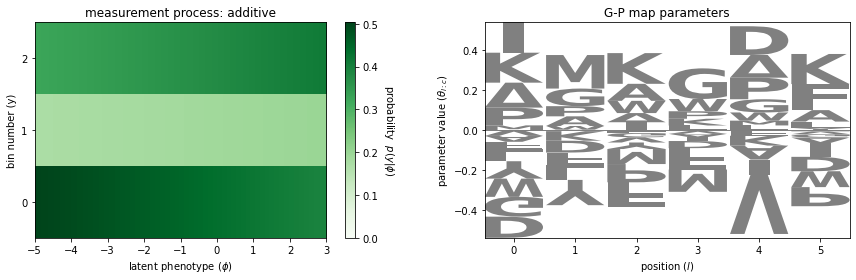

In [13]:
model = mavenn.load('splimlib_mpa_additive')

# Get G-P map parameters in matrix form
theta = model.get_theta(gauge='uniform')

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = model.model.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process = model.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,2,figsize=[12,4])

# Right panel: draw logo using logomaker
ax = axs[1]
logo = logomaker.Logo(theta['logomaker_df'], ax=ax)
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('G-P map parameters')

# left panel: draw measurement process as heatmap
ax = axs[0]
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process: additive')
cb = plt.colorbar(im, ax=ax)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout(w_pad=3)
fig.savefig('splimlib_additive_g-p_map_mpa_visualization.png')
plt.show()

The left-hand plot is a display of the measurement process (estimating the true phenotype from the NGS distribution). The right-hand plot is a plot of the genotype-phenotype map, showing how the model interprets the link between the amino acids at one sequence position, and the fitness. 

Looking  at the measurement map, there is a mild trend in the correct direction: variants abundant in bin 0 (low) have a negative phenotype, while variants abundant in bin 2 (high) have a positive phenotype. This trend does seem to suffer from much noise, compared to Figure 2 and Figure 5 in the preprint that describes MAVE-NN (https://www.biorxiv.org/content/10.1101/2020.07.14.201475v3).

# Neighbour epistasis model
Allowing epistasis only between neighbouring positions.

In [21]:
# Define model
model = mavenn.Model(regression_type='MPA',
                     L=L,
                     Y=Y,
                     alphabet=sml_alphabet,
                     gpmap_type='neighbor',
                     mpa_hidden_nodes=100)

# Set training data
model.set_data(x=x_train,
               y=y_train,
               shuffle=True)

# Fit model to data
model.fit(learning_rate=.005,
          epochs=1000,
          batch_size=500,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=True)

# Save model
model.save('splimlib_mpa_neighbour')

N = 56,591 observations set as training data.
Using 20.3% for validation.
Data shuffled.
Time to set data: 0.29 sec.
 
LSMR            Least-squares solution of  Ax = b

The matrix A has    45095 rows  and       78 cols
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =       78

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  2.511e+02  2.751e+04   1.0e+00  4.4e-01
     1  2.64950e-01  1.592e+02  2.285e+03   6.3e-01  1.0e-01  1.4e+02  1.0e+00
     2  1.20690e-01  1.553e+02  4.323e+02   6.2e-01  1.8e-02  1.6e+02  2.2e+00
     3  1.33290e-01  1.551e+02  2.046e+02   6.2e-01  7.9e-03  1.7e+02  2.6e+00
     4  1.04756e-01  1.550e+02  1.133e+02   6.2e-01  4.1e-03  1.8e+02  3.0e+00
     5  9.27031e-02  1.550e+02  8.612e+01   6.2e-01  3.0e-03  1.8e+02  4.1e+00
     6  7.79318e-02  1.550e+02  7.413e+01   6.2e-01  2.5e-03  1.9e+02  6.3e+00
     7  5.16626e-02  1.549e+02  5.91

Model loaded from these files:
	splimlib_mpa_neighbour.pickle
	splimlib_mpa_neighbour.h5


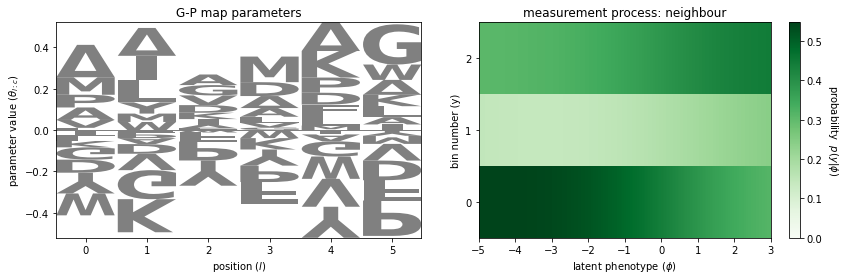

In [22]:
# Load model
model = mavenn.load('splimlib_mpa_neighbour')

# Get G-P map parameters in matrix form
theta = model.get_theta(gauge='uniform')

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = model.model.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process = model.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,2,figsize=[12,4])

# Left panel: draw logo using logomaker
ax = axs[0]
logo = logomaker.Logo(theta['logomaker_df'], ax=ax)
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('G-P map parameters')

# Right panel: draw measurement process as heatmap
ax = axs[1]
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process: neighbour')
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout(w_pad=3)
fig.savefig('splimlib_neighbour_g-p_map_mpa_visualization.png')
plt.show()

As in the additive model, the measurement process shows the right trend, although the spread in the colouring is still substantial.

Given our experience with the analysis of the active variants, this model should capture at least some epistasis in the G-P map (the two hydrophobics motif). However, the G-P map is rather impossible to interpret in a meaningful manner:
- the model suggests a preference deletions in positions where no deletion were, in fact, introduced to the library
- there is a preference of I/L in postion 7a (1 on chart), but not in 9/11 (3/4)
- it places K, P and D residues as contributing to activity in position 11 (4 on chart), when an I/L residue in fact strongly predominates in the active variants


### Pairwise model
Allowing epistasis between all pairs of positions (first order epistasis across the domain).

In [19]:
# Define model
model = mavenn.Model(regression_type='MPA',
                     L=L,
                     Y=Y,
                     alphabet=sml_alphabet,
                     gpmap_type='pairwise',
                     mpa_hidden_nodes=100)

# Set training data
model.set_data(x=x_train,
               y=y_train,
               shuffle=True)

# Fit model to data
model.fit(learning_rate=.005,
          epochs=1000,
          batch_size=500,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=True)

# Save model
model.save('splimlib_mpa_pairwise')

N = 56,591 observations set as training data.
Using 19.9% for validation.
Data shuffled.
Time to set data: 0.273 sec.
 
LSMR            Least-squares solution of  Ax = b

The matrix A has    45321 rows  and       78 cols
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =       78

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  2.520e+02  2.771e+04   1.0e+00  4.4e-01
     1  2.57861e-01  1.595e+02  2.174e+03   6.3e-01  9.6e-02  1.4e+02  1.0e+00
     2  1.41338e-01  1.559e+02  4.134e+02   6.2e-01  1.7e-02  1.6e+02  2.2e+00
     3  1.38557e-01  1.557e+02  1.921e+02   6.2e-01  7.5e-03  1.7e+02  2.8e+00
     4  1.09604e-01  1.557e+02  1.198e+02   6.2e-01  4.4e-03  1.7e+02  3.3e+00
     5  9.79046e-02  1.556e+02  9.743e+01   6.2e-01  3.4e-03  1.8e+02  4.6e+00
     6  7.75371e-02  1.556e+02  8.426e+01   6.2e-01  2.8e-03  1.9e+02  6.7e+00
     7  4.12142e-02  1.555e+02  6.3

Model loaded from these files:
	splimlib_mpa_pairwise.pickle
	splimlib_mpa_pairwise.h5


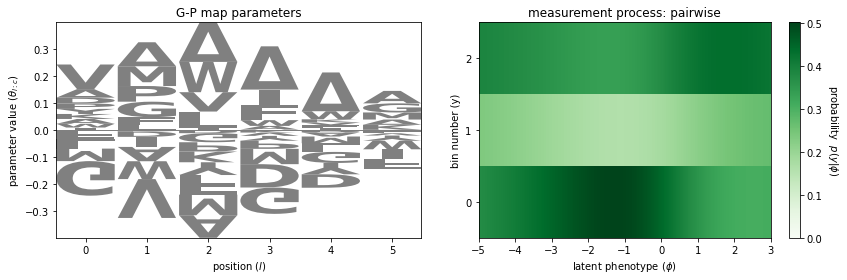

In [20]:
# Load model
model = mavenn.load('splimlib_mpa_pairwise')

# Get G-P map parameters in matrix form
theta = model.get_theta(gauge='uniform')

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = model.model.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process = model.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,2,figsize=[12,4])

# Right panel: draw logo using logomaker
ax = axs[1]
logo = logomaker.Logo(theta['logomaker_df'], ax=ax)
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('G-P map parameters')

# left panel: draw measurement process as heatmap
ax = axs[0]
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process: pairwise')
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout(w_pad=3)
fig.savefig('splimlib_pairwise_g-p_map_mpa_visualization.png')
plt.show()

Allowing pairwise epistasis, the measurement process makes no sense: variants abundant in the low gate have middle phenotype? If anything, the results should be better or similar to the neigbour model.

## Black box model

The black box  model is a neural network model without a clear mapping to the shape of the G-P map, allowing more nonlinearity in the MAVE-NN function. We include it here to test the upper limit of the extent to which the package can learn the G-P pattern from our data.

In [23]:
# Define model
model = mavenn.Model(regression_type='MPA',
                     L=L,
                     Y=Y,
                     alphabet=sml_alphabet,
                     gpmap_type='blackbox',
                     gpmap_kwargs={
                         'hidden_layer_sizes': [5]*5
                     })

# Set training data
model.set_data(x=x_train,
               y=y_train,
               shuffle=True)

# Fit model to data
model.fit(learning_rate=.005,
          epochs=1000,
          batch_size=500,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=False)

# Save model
model.save('splimlib_mpa_blackbox')

N = 56,591 observations set as training data.
Using 20.1% for validation.
Data shuffled.
Time to set data: 0.271 sec.
Epoch 1/1000
91/91 [==============================] - 0s 3ms/step - loss: 52004.3984 - I_var: -0.0068 - val_loss: 51460.7852 - val_I_var: 6.3264e-04
Epoch 2/1000
91/91 [==============================] - 0s 2ms/step - loss: 51797.9453 - I_var: -0.0010 - val_loss: 51437.5547 - val_I_var: 0.0012
Epoch 3/1000
91/91 [==============================] - 0s 2ms/step - loss: 51780.1992 - I_var: -1.3591e-04 - val_loss: 51430.1719 - val_I_var: 0.0015
Epoch 4/1000
91/91 [==============================] - 0s 2ms/step - loss: 51772.5391 - I_var: -5.4145e-04 - val_loss: 51456.5391 - val_I_var: 7.2639e-04
Epoch 5/1000
91/91 [==============================] - 0s 2ms/step - loss: 51780.3867 - I_var: -1.6829e-04 - val_loss: 51421.4922 - val_I_var: 0.0017
Epoch 6/1000
91/91 [==============================] - 0s 2ms/step - loss: 51749.1445 - I_var: 4.8490e-04 - val_loss: 51443.9453 - val_I_v

Model loaded from these files:
	splimlib_mpa_blackbox.pickle
	splimlib_mpa_blackbox.h5


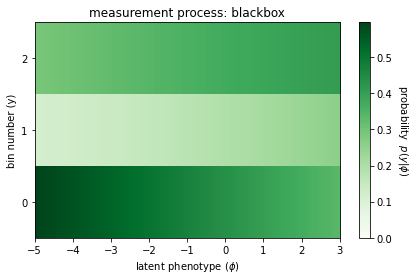

In [24]:
# Load model
model = mavenn.load('splimlib_mpa_blackbox')

# Get G-P map parameters in matrix form
theta = model.get_theta(gauge='uniform')

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = model.model.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process = model.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, ax = plt.subplots(1,1,figsize=[6,4])

im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process: blackbox')
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout(w_pad=3)
fig.savefig('splimbli_blackbox_mpa_visualization.png')
plt.show()

Here, the measurement process looks similar to the first two (additive and neighbour), though not obviously better. Whatever the blackbox model learned, somehow it cannot be visualised with the usual G-P map.

In [ ]:
# Show training history

# Compute likelihood information
I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.axhline(I_var, color='C2', linestyle=':', label='I_var_test')
ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training history')
ax.set_ylim([0, I_pred*1.2]);

#### Concluding comments:
1. The FACS-NGS data has more noise than the example included in the package publication; in fact, thoset data (sort-seq) had 10 bins, but only 0 or 1 values in the sorting matrix - as if each variant is strictly only sorted in a single FACS gate. We do not know in detail which data was used in Tareen et al., but their data look as if every sequence is only appearing in any one bin. In typical experimental FACS data, this will not be the case, as there is always some experimental variation that makes a sequence appear in more than one bin. In our dataset we have an experimental spread across the three bins (judging from the controls); with just three bins the resolution in the medium activity variants is low and oversampling also amplifies the spillover counts. While we are confident, based on the flow cytometry controls,  that >92% of the sequences recovered from the high activity gate encode active variants (8% false _positive_ rate), the high false _negative_ rate (~50%) means that one out of two beads encoding an active variant are sorted in the low activity gate. Although this does not hamper the informative power of variants recovered from the high activity gate, and allows for pooled analysis of active variants, it does increase the noise, as the variants are not strictly sorted in one FACS gate. In other words, in this particular dataset a variant's enrichment in the high gate is informative, while the presence of some sequencing reads in the low gate does not provide useful information. Finally, the noisier the FACS-NGS data, the harder it is to rank the variants by phenotype (=generate a latent phenotype value).
2. When the MAVE-NN algorithms attempt to create the genotype-phenotype map, a uniform alphabet for all positions is assumed. However, our library is focused. Since all 13 possible values (12 amino acids or no amino acid) appear in all 6 position, we suspect that the algorithm is trying to guess the preference for missing amino acids at all positions. Comparing this to the actual enrichment maps we show in the main paper, the algorithm is not actually succeeding in this task.

A combination of the above points takes the analysis back full circle: since it is hard to estimate the exact phenotype from the FACS-NGS data, it is not unreasonable to look at the active variants as a group. The targeted design of the library enables us to explore more positions and interactions in the D-domain given a limited sequencing depth, at the cost of requiring a targeted analysis of the results. We conclude that our exploration of enrichment patterns does show a fairly straightforward and biologically plausible picture despite possible limitations arising from noise.